# Ship Image Classification

##### The primary objective is to engineer a model that excels in both accuracy and efficiency for classifying diverse ship types.
##### The 6252 labelled photos from several ship categories in the foundational dataset offer a strong foundation for training the neural network. The weighted F1 score highlights the importance of a balanced approach in evaluation metrics, which is essential for practical applications in environmental protection, fisheries management, and marine surveillance. Supported through the strategic selection of InceptionV3, which is well-known for working well in transfer learning situations. However, the recognized constraints of InceptionV3, such as processing requirements and interpretability problems, point to possible areas for model deployment improvement.
##### The ship image classification dataset comprises images representing the following categories: 1. Cargo, 2. Military, 3. Carrier, 4. Cruise and 5. Tankers


# Importing Libraries

In [ ]:
import pandas as pd
import os
from PIL import Image
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from google.colab import drive
drive.mount('/content/drive')

# Ignore all warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read csv file using pandas and info about csv file

In [ ]:
# read csv file using pandas
df = pd.read_csv('/content/drive/MyDrive/CNST_PROJECT/archive/train/train.csv')

In [ ]:
# just print first five values from table
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
# Describes more about data
df.describe()

,category
count,6252.000000
mean,2.657550
std,1.528998
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [ ]:
#starting value and ending value
df.index

RangeIndex(start=0, stop=6252, step=1)

In [ ]:
#shape
df.shape

(6252, 2)

In [ ]:
# columns in dataset
df.columns

Index(['image', 'category'], dtype='object')

In [ ]:
#images names
df['image']

0       2823080.jpg
1       2870024.jpg
2       2662125.jpg
3       2900420.jpg
4       2804883.jpg
           ...     
6247    2881056.jpg
6248    1145083.jpg
6249    2898652.jpg
6250    2868175.jpg
6251    2784171.jpg
Name: image, Length: 6252, dtype: object

In [ ]:
#different classes
df['category']

0       1
1       1
2       2
3       3
4       2
       ..
6247    3
6248    2
6249    5
6250    3
6251    1
Name: category, Length: 6252, dtype: int64

In [ ]:
#five classes
df['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [ ]:
#sort all the classes
d = df['category'].value_counts()
d = sorted(d.items())

In [ ]:
# count of all classes and their count
dict(d)

{1: 2120, 2: 1167, 3: 916, 4: 832, 5: 1217}

In [ ]:
# different classes and their representation
dictclass = {1: 'Cargo',
             2: 'Military',
             3: 'Carrier',
             4: 'Cruise',
             5: 'Tankers'}

In [ ]:
dictclass

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

#Count plot of all classes

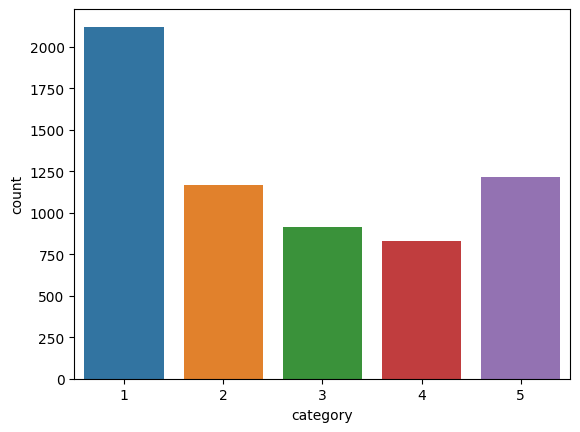

In [ ]:
# To check all the classes and their count check if class is balanced and balance by using sampling techniques
sns.countplot(x ='category', data = df)
plt.show()

#Check the random images size

In [ ]:
# check size of random image
image = Image.open('/content/drive/MyDrive/CNST_PROJECT/archive/train/images/1001524.jpg')

In [ ]:
width, height = image.size

In [ ]:
print("width: {}, height {}".format(width,height))

width: 210, height 158


In [ ]:
#check randomly size of another image
image = Image.open('/content/drive/MyDrive/CNST_PROJECT/archive/train/images/1011813.jpg')
width, height = image.size
print("width: {}, height {}".format(width,height))

width: 210, height 52


In [ ]:
# Set the target size for resizing all images in preprocessing
target_size = (128, 128)

In [ ]:
input_directory = '/content/drive/MyDrive/CNST_PROJECT/archive/train/images'

#Images Preprocessing

In [ ]:
resized_image_list = []
original_images_list = []
refactor_size = (128,128)

for i in range(df.shape[0]):
    image_path = os.path.join(input_directory, df["image"][i])
    img = Image.open(image_path)
    img = img.convert("RGB")
    img = img.resize(refactor_size)
    # Convert the image to a NumPy array and normalize pixel values to the range [0, 1]
    img = np.array(img) / 255.0

    resized_image_list.append(img)
    original_images_list.append(image_path)
resized_image_list = np.asarray(resized_image_list)

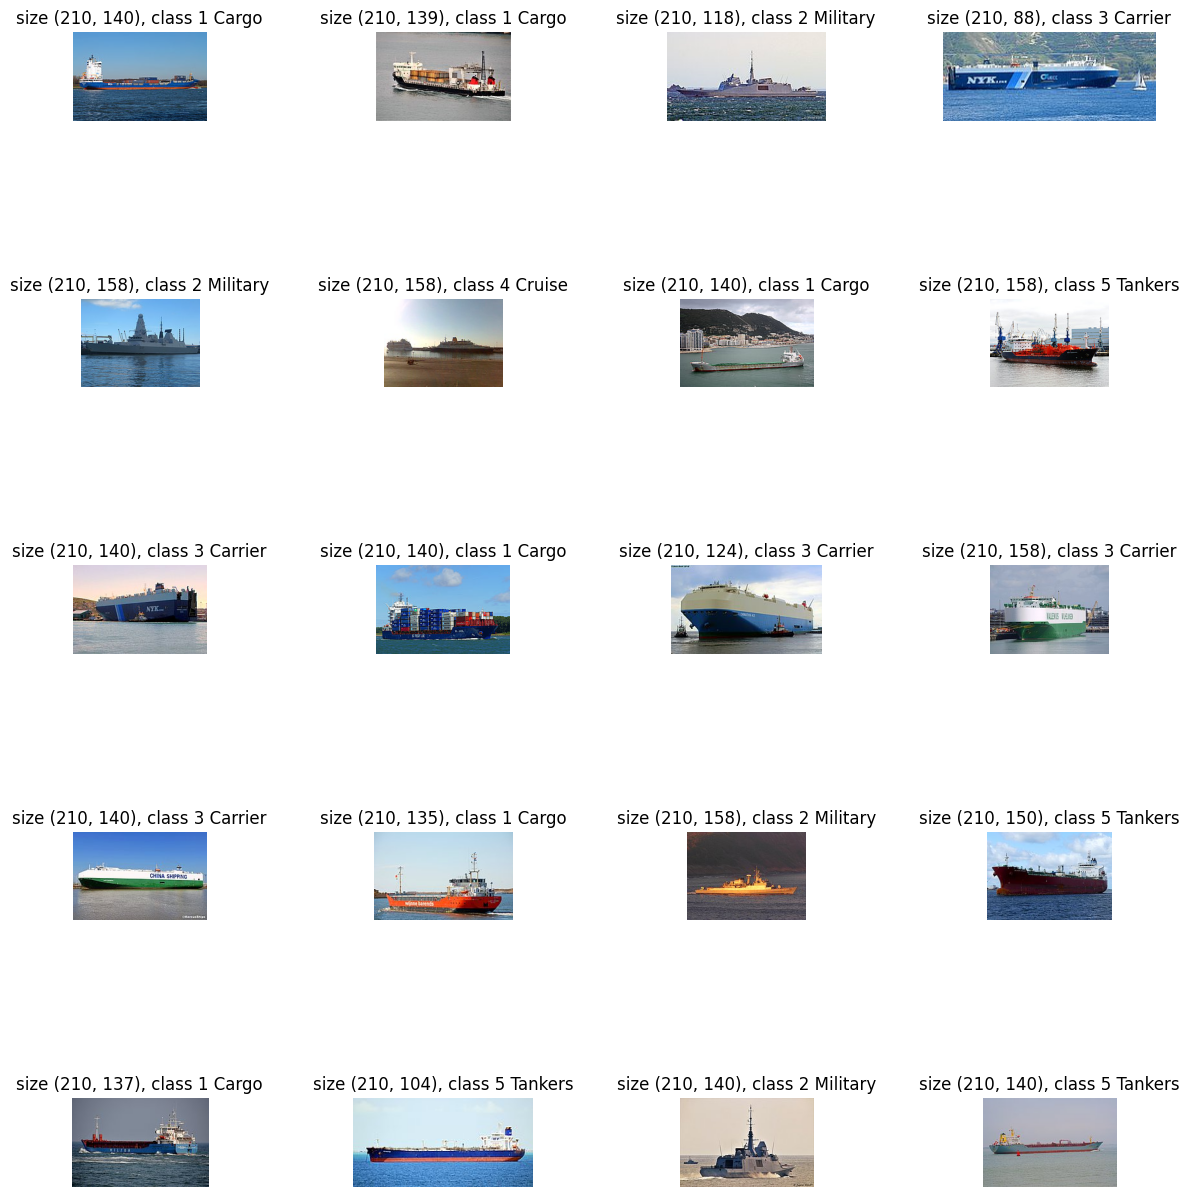

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=2)

# Iterate over the image files and plot them
for i in range(20):
    image_path = os.path.join(input_directory, original_images_list[i])
    img = Image.open(image_path)

    # Display the image
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].set_title("size {}, class {} {}".format(img.size,df['category'][i],dictclass[df['category'][i]]))
    axes[i // 4, i % 4].axis('off')

#Display images after preprocessing

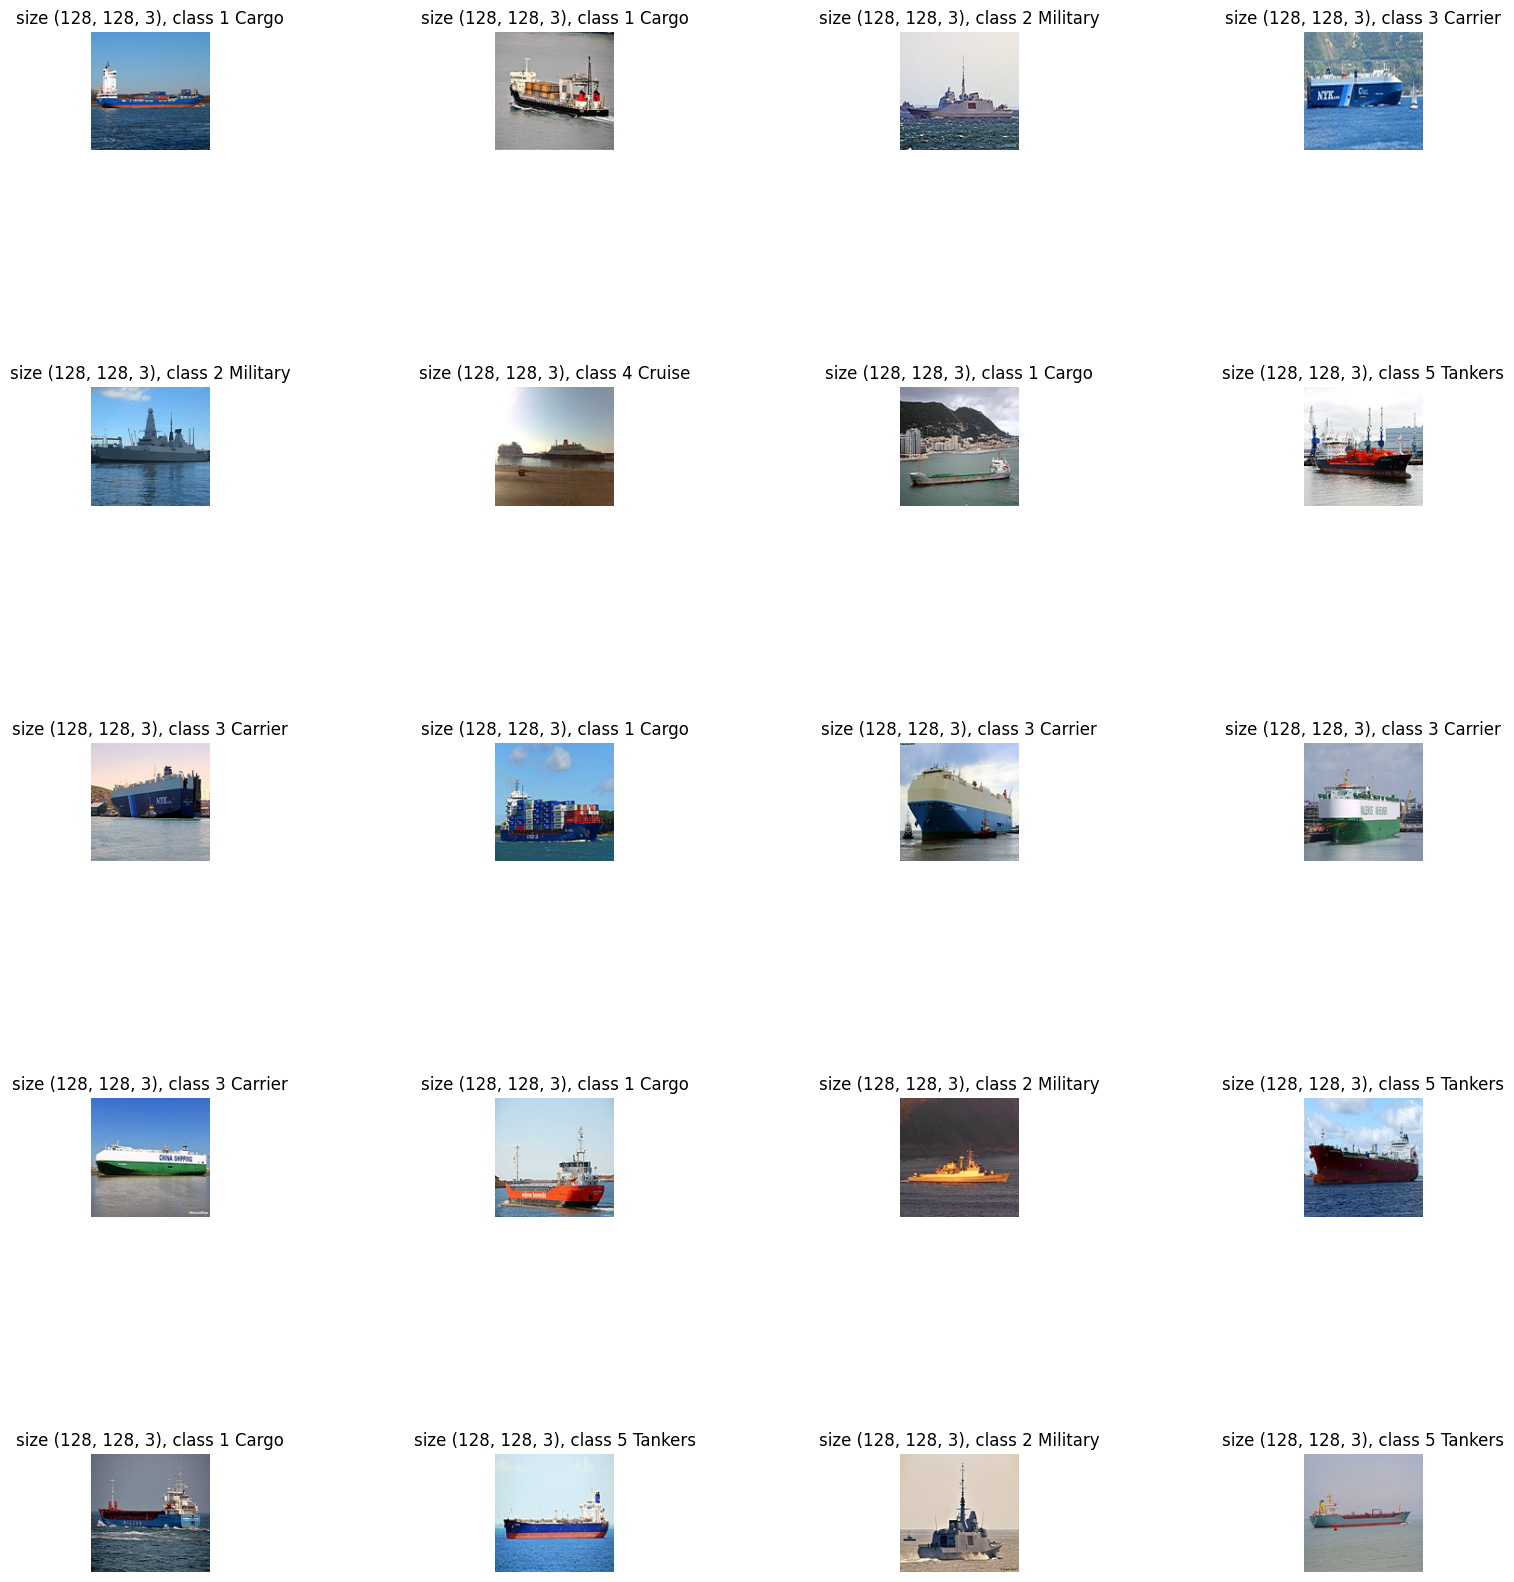

In [ ]:
fig,axes = plt.subplots(5, 4, figsize=(20,20))
fig.subplots_adjust(hspace=2)

# Iterate over the image files and plot them
for i in range(20):
    img = resized_image_list[i]
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].set_title("size {}, class {} {}".format(img.shape,df['category'][i],dictclass[df['category'][i]]))
    axes[i // 4, i % 4].axis('off')

In [ ]:
classes = df['category']-1

In [ ]:
classes

0       0
1       0
2       1
3       2
4       1
       ..
6247    2
6248    1
6249    4
6250    2
6251    0
Name: category, Length: 6252, dtype: int64

#Splitting the data in to Train and Test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(resized_image_list, classes)

#Build a base model Inception InceptionV3

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


#Build a sequential model adding layers flattten, dense, dropout and compile the model

In [ ]:
# Build a sequential model on top of the pre-trained model intergrating transfer learning model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # num_classes is the number of output classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

#Image Datagenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)

#Fit the model

In [ ]:
model.fit(datagen.flow(X_train, y_train, batch_size=128),
          steps_per_epoch=len(X_train) // 128,
          epochs=50)

Epoch 1/50
36/36 [==============================] - 77s 704ms/step - loss: 1.7711 - accuracy: 0.2622
Epoch 2/50
36/36 [==============================] - 23s 626ms/step - loss: 1.4680 - accuracy: 0.3675
Epoch 3/50
36/36 [==============================] - 25s 681ms/step - loss: 1.1795 - accuracy: 0.4856
Epoch 4/50
36/36 [==============================] - 23s 620ms/step - loss: 0.8897 - accuracy: 0.6021
Epoch 5/50
36/36 [==============================] - 22s 620ms/step - loss: 0.7245 - accuracy: 0.6928
Epoch 6/50
36/36 [==============================] - 24s 650ms/step - loss: 0.6289 - accuracy: 0.7531
Epoch 7/50
36/36 [==============================] - 24s 651ms/step - loss: 0.6222 - accuracy: 0.7781
Epoch 8/50
36/36 [==============================] - 22s 609ms/step - loss: 0.4858 - accuracy: 0.8156
Epoch 9/50
36/36 [==============================] - 23s 632ms/step - loss: 0.4157 - accuracy: 0.8560
Epoch 10/50
36/36 [==============================] - 23s 626ms/step - loss: 0.4030 - accura

#Save the model

In [ ]:
import joblib
joblib.dump(model, 'inception_filename.joblib')
# Load the model from the file
loaded_model = joblib.load('inception_filename.joblib')

# Now you can use loaded_model to make predictions
pred = loaded_model.predict(X_test)

49/49 [==============================] - 5s 46ms/step


#Accuracy of the test data

In [ ]:
accuracy = accuracy_score(y_test, np.argmax(pred,axis=1))
accuracy

0.891874600127959

#Confusion matrix

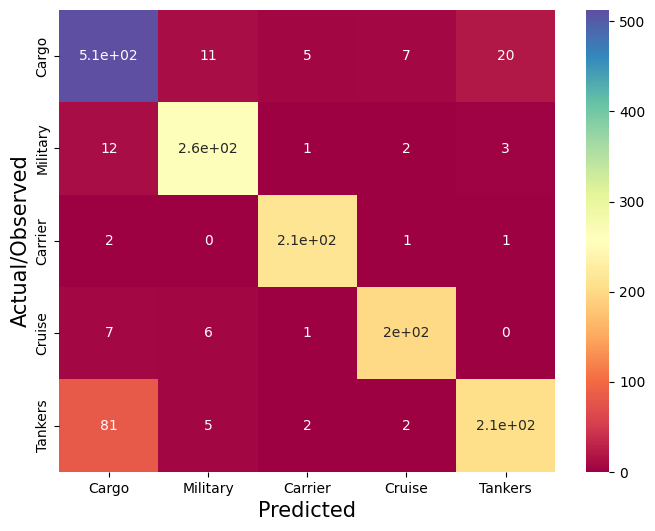

In [ ]:
plt.figure(figsize = (8,6))
labels = ["Cargo","Military","Carrier","Cruise","Tankers"]
sns.heatmap(cm,
            annot=True,
            cmap="Spectral",xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [ ]:
cm=confusion_matrix(y_test, np.argmax(pred,axis=1))
cm

array([[513,  11,   5,   7,  20],
       [ 12, 263,   1,   2,   3],
       [  2,   0, 213,   1,   1],
       [  7,   6,   1, 199,   0],
       [ 81,   5,   2,   2, 206]])

# Classification Report

In [ ]:
print(classification_report(y_test, np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       556
           1       0.92      0.94      0.93       281
           2       0.96      0.98      0.97       217
           3       0.94      0.93      0.94       213
           4       0.90      0.70      0.78       296

    accuracy                           0.89      1563
   macro avg       0.91      0.89      0.90      1563
weighted avg       0.89      0.89      0.89      1563

